# Permutation test for unpaired or independent samples data

We now look at the case of unpaired data - data in which we wish to compare two groups but there are no particular links between individuals in one group and individuals in another group

Examples of experimental designs using independent samples would be (say) a comparison of science and humanities students, or first- and final-year students, where the individuals in each group are distinct.

### Set up Python libraries

As usual, run the code cell below to import the relevant Python libraries

In [1]:
# Set-up Python libraries - you need to run this but you don't need to change it
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
sns.set_theme(style='white')
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Toy example

[A toy example is an example with a very small dataset, just to show how it works]


#### Question & design

We hypothesise that cat owners eat more yoghurt than dog owners 

We decide on an **independent samples** design in which a group of cat owners are compared to an unrelated group of dog owners. 

#### Hypotheses

We can state our hypotheses as follows:

$\mathcal{H_o}:$ The difference in the mean number of yoghurts eaten by cat owners and dog owners is zero
* mean(cat owners' yoghurt consumption) - mean(dog owners' yoghurt consumption) = 0

$\mathcal{H_a}:$ Cat owners eat more yoghurt
* mean(cat owners' yoghurt consumption) > mean(dog owners' yoghurt consumption) = 0

This is a one-tailed (directional) alternative hypothesis

#### Data

We survey five cat owners and four dog owners and ask how many times in the last week they ate yogurt. We obtain the following data:

In [2]:
yog = pd.read_csv('https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/data/yoghurt.csv')
yog

,Pet,Yoghurt
0,cat,0
1,cat,7
2,cat,5
3,cat,2
4,cat,13
5,cat,1
6,cat,8
7,cat,6
8,cat,3
9,cat,5


Let's plot the data:

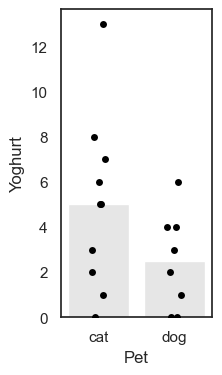

In [3]:
plt.figure(figsize=(9,4))
plt.subplot(1,4,1)
sns.barplot(data=yog, x='Pet', y='Yoghurt', color=[0.9,0.9,0.9], errorbar=None)
sns.stripplot(data=yog, x='Pet', y='Yoghurt', color=[0,0,0]) # this bit plots the dots
plt.show()

We note that the mean number of yoghurts eaten is higher for cat owners, but this may be skewed by one cat-owning yogurt enthusiast.
                                                                                                                     
### Test statistic

We need to summarize the difference in yoghurt consumption as a number. 

This mean difference, <tt>mean(Cat owners) - mean(Dog owners))</tt>, is calculated as follows:

In [4]:
yog.query('Pet == "cat"').Yoghurt.mean() - yog.query('Pet == "dog"').Yoghurt.mean()

2.5

On average, cat owners eat yoghurt 2.5 more times per week than dog owners. Possibly because cats stealing yoghurt are cute.

### Is the result statistically significant? 

Even if there were no true pet-based differences in yoghurt consumption, if we picked a sample of random cat- and dog-owners and measured their yoghurt consumption we wouldn't expect the difference in average yoghurt consupmtion to be *exactly zero* - just by chance the cat owners would sometimes eat more yogurt, and vice versa.

Is it plausible that the pet-based difference we observed (cat owners eat yoghurt 2.5 more times per week than dog owners) arose due to chance from a situation in which there is no true pet-based difference in yoghurt consumption (ie, the *null hypothesis is true*)?

In that case, it would be just chance whether a person is labelled as a cat- or dog-owner.


### Permutation

To work out how likely it would be to get a test statistic (difference in mean yogurt consumtion bbetwee the cat- and dog groups) as large as 2.5, we are going to do is shuffle the data around to create many new (re)samples in which, **people are randomly moved between groups**

Within each resample, some individuals will retain their true pet identity, and some will be relabelled; which individuals are which will differ between resamples.

For each resample, we then calculate the mean difference in yogurt consumption, <tt>mean(Cat-Dog)</tt>.

After repeating the process thousands of times, we can ask on what proportion of random resamples we get a values of <tt>mean(Cat-Dog)</tt> at least as large as our observed difference, 2.5.

In this case as data are unpaired, we don't need to preserve pared realationships - ie we can swap the pet-labels for any two people in the sample of 18. However, we do still want to preserve the non-pet-based features of the dataset, namely the sample sizes (10 cat owners and 8 dog owners).

Shuffling within our sample of 18 will also preserve the overall features of the dataset:

**Non pet-based effects (to be preserved):**
* Most people eat yoghurt less than once a day
* Some people eat loads of yoghurt
    * ie the distriution of differences has positive skew 

**Potential pet-based effects (to be "shuffled out")**:
* The number of times yoghurt is eaten tends to be higher for cat owners
* The outlier individual who ate loads of yoghurt was a cat owner



### Run the simulation

To generate new simulated datasets, we will shuffle around the datapoints in our original dataset. 

Which ones can we shuffle?

* We assume there are no pet-based differences, so we can swap the pet-labels for any individuals in the sample
* We stick to the original sample sizes, ie 10 people should always be labelled as cat-owners and 8 as dog-owners

Conceptually, we would achieve this by randomly re-ordering the 18 values in the 'Yogurt' column so that a different 10 fall into rows laelled 'cat'

### Visualizing randoms shuffles in the unpaired data

Let's see how the difference of means changes over a few random shuffles.

Below I generate 4 random shuffles of our yoghurt data (in which individuals are randomly relabelled as cat- or dog-owners, maintaining the correct number of cat- and dog-owners), and plot the outcomes:

<img src= "https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/images/MT_wk5_4PermutationsInd.png" width="99%" />




Note that **each individual can move between the 'cat' and 'dog' group at random**, but there are always 10 people in the 'cat' group and 8 people in the 'dog' group.

You can see that the difference of means (difference in heights of the bars) depends on whether more of the high-yoghurt individuals are assigned as cat owners, and also depends quite a lot on which group the 13-yoghurt individual ends up in.

## Run 10,000 shuffles

To get a fine-grained estimate of how likely it is to get a test statistic of 2.5 due to chance, we run a *lot* of shuffles - say 10,000.

We can do this using a function from the library `scipy.stats`, called `scipy.stats.permutation_test()`

First of all we will run this (using the code block below) and learn about the output. Afterwards we will have a closer look at the Python syntax including defining a function.

In [5]:
def dMeans(x, y):
    return np.mean(x)-np.mean(y)

results = stats.permutation_test((yog.query('Pet == "cat"').Yoghurt, yog.query('Pet == "dog"').Yoghurt), dMeans, 
                                  permutation_type='independent', alternative='greater', n_resamples=10000)
print(results)

PermutationTestResult(statistic=2.5, pvalue=0.0683931606839316, null_distribution=array([-1.55 , -0.875,  1.15 , ...,  2.95 , -2.   , -0.875]))



The results are displayed below the code box; there are number of outputs from the test (contained in the parentheses)

* **statistic** - the test statistic (mean difference) from our actual data, ie 2.5
* **pValue** - the proportion of shuffles in which a result greater than 2.5 was obtained (due to chance)
* **null distribution** - this contains all 10,000 difference of mean values, for the 10,000 shuffles

### The Null Distribution

The **null distribution** is the set of 10,000 values we get for the difference of mean yoghurt consumption for (cat owners - dog owners), from our 10,000 shuffles (the equivalent of the red numbers on the 4-permutation example above)

Let's plot the null distribution in a histogram:


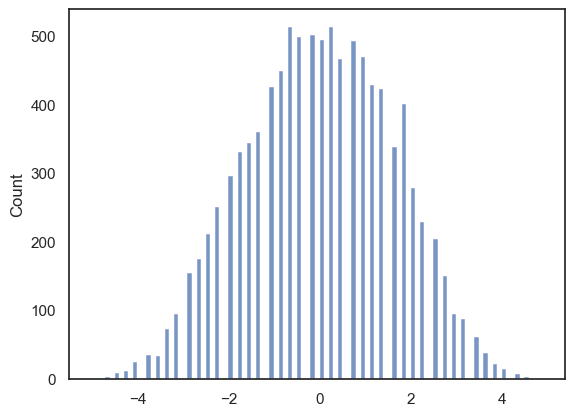

In [6]:
sns.histplot(results.null_distribution, bins=np.arange(-5,5,0.1))
plt.show()

The histogram looks a bit spikey because for this dataset (which is small and has several repeated values) there are a limited number of possible values for the means of a groups of 8 and a group of 10.

In any case we can see that the observed difference between cat and dog owners' mean consumption (+2.5) is quite rare but not completely extreme.

### The $𝑝$-value¶

We can calculate the exact proportion of cases in which the difference of means for cat- minus dog-owners exceeds the value we observed in our original sample, 2.5. 

In [7]:
# check which values is the null distribution are greater than 4.6 and code as 1/0
# then use the numpy function np.mean() to get the avergae of those ones and zeros (ie he proportion of 1s)
np.mean(results.null_distribution >= 2.5)

0.0683

This proportion is 0.064 or 6.4%.

This tells us that if we simulate a situation in which pet ownership does not determine the number of times yoghurt is eaten (but preserving some other important features of the dataset like the high skew), there is still almost a 5% chance that we would get an apparent pet-based difference as large as the one we observed in our 'real' data.

The probability that the test statistic (in this case, the difference in mean times yoghurt is eaten) would be observed if the null hypothesis were true, is sometimes called the $𝑝$-value.

Our permutation test shows that the $𝑝$-value associated with the observed difference of means is 0.047 or 4.7%.

The result is considered statistically significant if $𝑝$ is smaller than some predetermined level, known as $\alpha$. Usually $\alpha=0.05$ or $\alpha=0.01$ is used; this result is not quite significant if $\alpha=0.05$ but not significant if $\alpha=0.01$. 

## Syntax of `stats.permutation_test()`

Let's have a look at the Python code to run the permutation test.

Firstly, we had to give the function `stats.permutation_test()` our two samples. In this case, the data are in 'long form', ie the pet category is defined in one column of the dataset, so cat owners and dog owners are in different rows. We therefore identify our categories useing `df.query()` with the column we want (<tt>Yoghurt</tt>) tacked on the end:

`(yog.query('Pet == "cat"').Yoghurt, yog.query('Pet == "dog"').Yoghurt)`

Secondly, to tell `stats.permutation_test()` the test statistic we want to get the null distribution of, we had to pass it a *function* that calculates that test statistic. We created that function, `dMeans()`, using a function definition, before running the permutation test


### Arguments

When running the permutation test, we have to specify some arguments

* **n_resamples** the number of shuffles to do.
* **alternative** - whether to do a one-tailed test (and in whcih direction: 'greater' counts how many shuffles result in test statistic values greater than the one obtained from unshuffled data) or a two tailed test
* **permutation_type** - pairings, samples, or independent. These are for test of correlation, paired data and unpaired data respectively.

Here we are testing for a difference of means in *independent* (unpaired) samples, so we choose `permutation_type='independent'` - this randomly shuffles all the datapoints and assignes them randomly to the groups cat/dog.

## Recap

To run a permutation test on unpaired data, we mixed up all the individuals in the sample regardless of category (pet ownership), and randomly split them into two groups. We kept the original group sizes (10 and 8 in this case), as we want to retain the characteristics of the original dataset that one group is larger

For each shuffle we calculated the mean yoghurt consuption for each 'pet' group. 

Permutation testing in this way gives us a null distribution for the difference of means. Values of difference of means that occur rarely in the null distribution are considered statistically significant.
    
To run the permutation test with <tt>scipy.stats</tt> we need the option `permutation_type='independent'`